In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import math

from keras.preprocessing.text import *
from keras.preprocessing.sequence import skipgrams, pad_sequences

from keras.models import Sequential
import keras.layers as layers
import keras.models as models
from keras.layers import Dense, Activation, Embedding, Flatten
from keras.metrics import categorical_accuracy, binary_accuracy
from keras.layers import Bidirectional, LSTM, GRU, Dense

import keras.backend as K
import tensorflow as tf


Using TensorFlow backend.


In [2]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df_train = pd.read_csv('input/train.csv')

x_train = df_train['comment_text']
y_train = df_train[categories].as_matrix()

display(df_train.head())
m = x_train.shape[0]
display(f'total m = {m}')

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


'total m = 159571'

In [3]:
max_len = 350
epochs = 6
one_weight = 0.9


In [4]:
embedding_index = {}

f = open('input/glove.6B.300d.txt')
for line in f:
    values = line.split()
    w = values[0]
    weights = np.asarray(values[1:], dtype='float32')
    embedding_index[w] = weights
f.close()

In [5]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(texts=x_train)

vocabulary_size = len(tokenizer.word_index)
sequences = tokenizer.texts_to_sequences(texts=x_train)

max_seq_len = 0
for sequence in sequences:
    max_seq_len = max(max_seq_len, len(sequence))

print('max length {}'.format(max_seq_len))

min_seq_len = max_seq_len
for sequence in sequences:
    min_seq_len = min(min_seq_len, len(sequence))
    
print('min length {}'.format(min_seq_len))

max length 1403
min length 1


In [6]:
np.mean([len(x) for x in sequences])


68.221569082101382

In [7]:
embedding_dim = 300

embedding_matrix = np.zeros((vocabulary_size + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [8]:
def init_weighted_binary_crossentropy(one_weights, i):

    def weight_binary_crossentropy(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), (1.0 - K.epsilon()))
        
        o_terms = tf.multiply(tf.multiply(y_true, tf.log(y_pred)), one_weights[i])
        z_terms = tf.multiply(tf.subtract(1.0, y_true), tf.log(tf.subtract(1.0, y_pred)))

        terms = tf.add(o_terms, z_terms)
        terms = tf.negative(K.mean(terms))

        return K.mean(terms)
    
    return weight_binary_crossentropy

c_count = [15294, 1595, 8449, 478, 7877, 1405]
o_weights = [max(1.0, math.log(one_weight * m / float(c))) for c in c_count]
print(o_weights)

embedding = Embedding(vocabulary_size + 1, embedding_dim, weights=[embedding_matrix], trainable=False)

inputs = layers.Input(shape=(max_len,), name='input')
outputs = [embedding(inputs) for i in range(len(categories))]
outputs = [layers.Bidirectional(layers.LSTM(16, name=c))(output) for output, c in zip(outputs, categories)]
outputs = [layers.Dense(6, activation='relu', name='dense1_{}'.format(c))(output) for output, c in zip(outputs, categories)]
outputs = [layers.Dense(1, activation='sigmoid', name='out_{}'.format(c))(output) for output, c in zip(outputs, categories)]
loss = [init_weighted_binary_crossentropy(o_weights, i) for i in range(len(categories))]

input_model = models.Model(inputs=inputs, outputs=outputs)
input_model.compile(optimizer='adam', loss=loss, metrics=[binary_accuracy])

[2.2396678539649777, 4.500254712350204, 2.8330803574163035, 5.705272995077692, 2.903181327865824, 4.627091145801302]


In [9]:
batch_size = 1024

def inputs():
    padded_sequences = pad_sequences(sequences=sequences, maxlen=max_len, padding='post')
    x_list = []
    y_list = []
    for sequence, y_train_val in zip(padded_sequences, y_train):
        x_list.append(sequence)
        y_list.append(y_train_val)
    return np.array(x_list), np.array(y_list)

x, y = inputs()

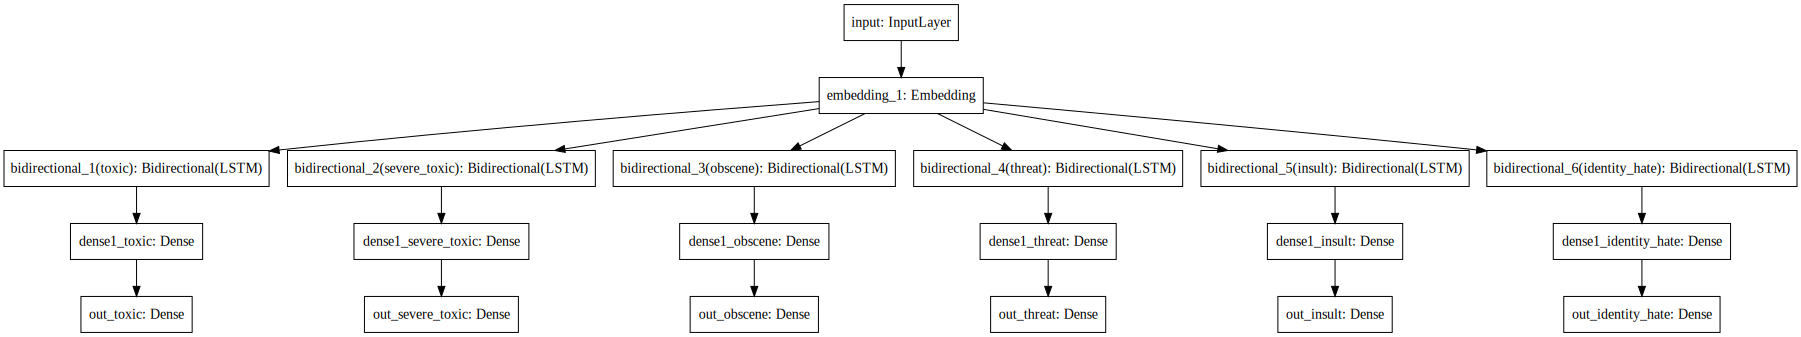

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(input_model).create(prog='dot', format='svg'))

In [11]:
hist = input_model.fit(x=[x], y=[y[:,0], y[:,1], y[:,2], y[:,3], y[:,4], y[:,5]], epochs=epochs, batch_size=batch_size, shuffle=True)

print(hist.history.items())

Epoch 1/6
159571/159571 [==============================] - 2585s 16ms/step - loss: 1.6635 - out_toxic_loss: 0.3733 - out_severe_toxic_loss: 0.2158 - out_obscene_loss: 0.2878 - out_threat_loss: 0.1417 - out_insult_loss: 0.4052 - out_identity_hate_loss: 0.2397 - out_toxic_binary_accuracy: 0.9215 - out_severe_toxic_binary_accuracy: 0.9876 - out_obscene_binary_accuracy: 0.9470 - out_threat_binary_accuracy: 0.9961 - out_insult_binary_accuracy: 0.9244 - out_identity_hate_binary_accuracy: 0.9704
Epoch 2/6
159571/159571 [==============================] - 2587s 16ms/step - loss: 0.7660 - out_toxic_loss: 0.2097 - out_severe_toxic_loss: 0.0704 - out_obscene_loss: 0.1355 - out_threat_loss: 0.0788 - out_insult_loss: 0.1690 - out_identity_hate_loss: 0.1026 - out_toxic_binary_accuracy: 0.9465 - out_severe_toxic_binary_accuracy: 0.9860 - out_obscene_binary_accuracy: 0.9709 - out_threat_binary_accuracy: 0.9970 - out_insult_binary_accuracy: 0.9613 - out_identity_hate_binary_accuracy: 0.9888
Epoch 3/6
15

In [12]:
#re-run additional epochs
additional_epochs = 0
input_model.fit(x=[x], y=[y[:,0], y[:,1], y[:,2], y[:,3], y[:,4], y[:,5]], epochs=additional_epochs, batch_size=batch_size, shuffle=True)



In [13]:
y_pred = input_model.predict(x=[x[0:1000, :]])

In [14]:
cat_max = [np.max(y_p) for y_p in y_pred]

display(cat_max)

y_pred_labels = np.zeros((y_pred[0].shape[0], len(categories)))
print(y_pred_labels.shape)

train_threshold = np.multiply(cat_max, 0.575)
display(train_threshold)

for threshold, i in zip(train_threshold, range(len(categories))):
    y_pred_labels[np.array(y_pred[i] >= threshold).reshape(-1), i] = 1
    y_pred_labels[np.array(y_pred[i] < threshold).reshape(-1), i] = 0


[0.99688786, 0.87310791, 0.99506867, 0.49682394, 0.97980791, 0.9181394]

(1000, 6)


array([ 0.57321054,  0.50203705,  0.57216448,  0.28567377,  0.56338954,
        0.52793014], dtype=float32)

In [15]:
display(y_pred_labels)



array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train[0:1000,:], y_pred_labels)

0.89700000000000002

In [17]:
df_test = pd.read_csv('input/test.csv')

x_test = df_test['comment_text']

print(x_test.shape)

(153164,)


In [18]:
sequences_test = tokenizer.texts_to_sequences(x_test)
padded_sequences_test = pad_sequences(sequences=sequences_test, maxlen=max_len, padding='post')

print(len(padded_sequences_test))

153164


In [19]:
x_test = [padded_sequences_test]
y_test_pred = input_model.predict(x=x_test)

In [20]:
y_test_pred_labels = np.zeros((y_test_pred[0].shape[0], len(categories)))

test_cat_max = [np.max(y_p) for y_p in y_test_pred]

display(test_cat_max)


[0.99860913, 0.97546601, 0.99671078, 0.64208025, 0.9836511, 0.98601252]

In [21]:
threshold = np.multiply(test_cat_max, 0.5)

print(threshold)

for t, i in zip(threshold, range(len(threshold))):
    y_test_pred_labels[np.array(y_test_pred[i] >= t).reshape(-1), i] = 1

display(y_test_pred_labels)

[ 0.49930456  0.48773301  0.49835539  0.32104012  0.49182555  0.49300626]


array([[ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  1.,  0.,  1.,  0.]])

In [22]:
df_submission = pd.DataFrame()
df_submission['id'] = df_test['id']
for c, i in zip(categories, range(len(categories))):
    df_submission[c] = y_test_pred_labels[:, i]
   
print(df_submission.shape)

df_submission.to_csv('output/lstm_6_glve_4B_09_350_6e_threshold_050_input_1_submission.csv',index=False)

(153164, 7)
